In [2]:
#!/usr/bin/env python
"""
A script to demonstrate how to use your own source model
"""
from __future__ import division, print_function
import matplotlib.pyplot as plt
import bilby
import numpy as np
%matplotlib inline

In [3]:
# First set up logging and some output directories and labels
outdir = 'outdir_new_model'
label = 'create_your_own_source_model'
sampling_frequency = 4096
duration = 1

In [4]:
# Here we define our source model - this is the sine-Gaussian model in the
# frequency domain.
def sine_gaussian(f, A, f0, tau, phi0, geocent_time, ra, dec, psi):
    arg = -(np.pi * tau * (f - f0))**2 + 1j * phi0
    plus = np.sqrt(np.pi) * A * tau * np.exp(arg) / 2.
    cross = plus * np.exp(1j * np.pi / 2)
    return {'plus': plus, 'cross': cross}

In [5]:
#testing
sine_gaussian(f=np.array([500,505]), A=1e-23, f0=100, tau=1, phi0=0, geocent_time=0,
                            ra=0, dec=0, psi=0)

{'plus': array([0.+0.j, 0.+0.j]), 'cross': array([0.+0.j, 0.+0.j])}

In [6]:
# We now define some parameters that we will inject
injection_parameters = dict(A=1e-23, f0=100, tau=1, phi0=0, geocent_time=0,
                            ra=0, dec=0, psi=0)

In [7]:
# Now we pass our source function to the WaveformGenerator
waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=sine_gaussian)

00:16 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: __main__.sine_gaussian
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [8]:
# Set up interferometers.
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 3)
injection = ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)

/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.6/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
00:16 bilby WARNING : Injecting signal outside segment, start_time=-3, merger time=0.
00:16 bilby INFO    : Injected signal in H1:
00:16 bilby INFO    :   optimal SNR = 3.19
00:16 bilby INFO    :   matched filter SNR = 3.23+0.85j
00:16 bilby INFO    :   A = 1e-23
00:16 bilby INFO    :   f0 = 100
00:16 bilby INFO    :   tau = 1
00:16 bilby INFO    :   phi0 = 0
00:16 bilby INFO    :   geocent_time = 0
00:16 bilby INFO    :   ra = 0
00:16 bilby INFO    :   dec = 0
00:16 bilby INFO    :   psi = 0
00:16 bilby WARNING : Injecting signal outside segment, start_time=-3, merger time=0.
00:16 bilby INFO    : Injected signal in L1:
00:16 bilby INFO    :   optimal SNR = 3.77
00:16 bilby INFO    :   matched filter SNR = 3.25+0.72j
00

### Looking at the data
Okay, we have spent a bit of time now initializing things. Let's check that everything makes sense. To do this, we'll plot our analysis data alongwise the amplitude spectral density (ASD); this is just the square root of the PSD and has the right units to be comparable to the frequency-domain strain data. We also add the "injection", here we plot the absolute value of the (complex) plus polarization.

In [23]:
#checking values
H1.strain_data.frequency_mask[0:50]
#therefore it takes value starting from 20Hz

NameError: name 'H1' is not defined

In [ ]:
#checking values
H1.strain_data.frequency_array[0:50]

In [ ]:
#checking values
H1.frequency_array[0:50]

In [ ]:
#while ploting it only takes the real part
H1.strain_data.frequency_domain_strain[idxs]

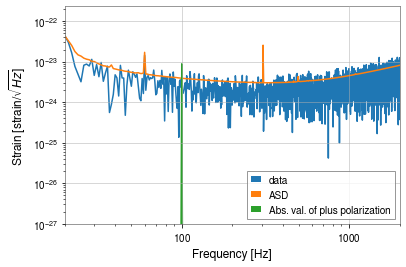

In [30]:
H1 = ifos[0]
H1_injection = injection[0]

fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]),
          label="data")
ax.loglog(H1.frequency_array[idxs],
          H1.amplitude_spectral_density_array[idxs],
          label="ASD")
ax.loglog(H1.frequency_array[idxs],
          np.abs(H1_injection["plus"][idxs]),
          label="Abs. val. of plus polarization")

'''L1 = ifos[1]
L1_injection = injection[1]

ax.loglog(L1.frequency_array[idxs]+5,
          L1.amplitude_spectral_density_array[idxs],
          label="ASD")'''

ax.set_xlim(20,2000)
ax.set_ylim(1e-27,2.327737159425905e-22)


ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax.legend()
plt.show()

In [31]:
# Here we define the priors for the search. We use the injection parameters
# except for the amplitude, f0, and geocent_time
prior = injection_parameters.copy()
prior['A'] = bilby.core.prior.LogUniform(minimum=1e-25, maximum=1e-21, name='A')
prior['f0'] = bilby.core.prior.Uniform(90, 110, 'f')

In [32]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator)

In [33]:
import smtplib
from email.message import EmailMessage

def email_alert(subject, body, to):
    msg =  EmailMessage()
    msg.set_content(body)
    msg['subject'] = subject
    msg['to'] = to
    
    
    user = "hemantaphurailatpam@gmail.com"
    msg['from'] = user
    password = "syrgxspjntbuzyoz"
    
    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.starttls()
    server.login(user, password)
    server.send_message(msg)
    
    server.quit()
    

In [34]:
result = bilby.core.sampler.run_sampler(
    likelihood, prior, sampler='dynesty', outdir=outdir, label=label,
    resume=False, sample='unif', injection_parameters=injection_parameters)

if __name__ == '__main__':
    email_alert("bilby", "running code got completed", "hemantaphurailatpam@outlook.com")

21:31 bilby INFO    : Running for label 'create_your_own_source_model', output will be saved to 'outdir_new_model'
21:31 bilby INFO    : Using lal version 7.0.0
21:31 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v6.76;Id: 384ac5e4b9c95803607658118ba361dfc353dade;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
21:31 bilby INFO    : Using lalsimulation version 2.2.0
21:31 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v6.76;Id: 384ac5e4b9c95803607658118ba361dfc353dade;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
21:31 bilby INFO    : Search parameters:
21:31 bilby INFO    :   A = LogUniform(minimum=1e-25, maximum=1e-21, name='A', latex_label='A', unit=None, boundary=None)
21:31 bilby INFO    :   f0 = Uniform(minimum=90, maximum=110, name='f', latex_label='f', unit=None, boundary=None)
21:31 bilby INFO    :   tau = 1
21:31 bilby INFO    :   phi0 = 0
21:31 bilby INFO    :   geocent_ti

0it [00:00, ?it/s]

21:31 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'unif', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fa649e039e8>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
21:31 bilby INFO    : Checkpoint every check_point_delta_t = 600s
21:31 bilby INFO    : Using dynesty version 1.0.1
21:31 bilby INFO    : Generating initial points from the pri

7132it [03:45, 68.33it/s, bound:84 nc:  5 ncall:8.7e+04 eff:8.2% logz-ratio=-0.07+/-0.06 dlogz:0.101>0.1]     

21:35 bilby INFO    : Written checkpoint file outdir_new_model/create_your_own_source_model_resume.pickle
21:35 bilby INFO    : Writing 3469 current samples to outdir_new_model/create_your_own_source_model_samples.dat


7139it [03:52, 30.67it/s, bound:84 nc:  1 ncall:8.7e+04 eff:9.3% logz-ratio=0.03+/-0.08 dlogz:0.000>0.1] 



21:35 bilby INFO    : Sampling time: 0:03:41.613696
21:35 bilby INFO    : Summary of results:
nsamples: 8139
ln_noise_evidence: -4123.216
ln_evidence: -4123.191 +/-  0.079
ln_bayes_factor:  0.025 +/-  0.079



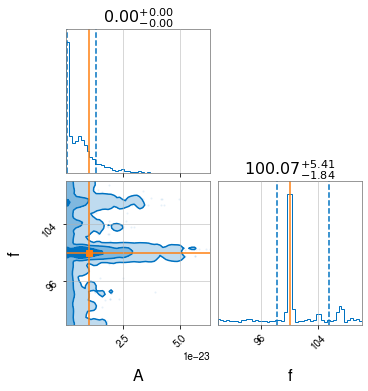

In [35]:
result.plot_corner()